In [407]:
import pandas as pd
from bs4 import BeautifulSoup
from IPython.display import Image
import requests
import tweepy
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading From Twitter Archive

In [3]:
# Getting Twitter archive data read from csv
twt = pd.read_csv('twitter-archive-enhanced.csv')
twt.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [4]:
# getting column for future referencing and to avoid any mismatches
twt.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [5]:
#getting the shape of the file
twt.shape

(2356, 17)

In [6]:
#gettting info to get the quality issues and missing data progrimatically 
twt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

## GATHERING the info 

in_reply_to_status_id , in_reply_to_user_id --> has a lot of missing data 

retweeted_status_id ,  retweeted_status_user_id, retweeted_status_timestamp --> has a lot of missing data but less than the 1st line columns

we have total of 17 colummns

# Reading the Image Prediction

In [7]:
#reading the image predictions
# we used the sep as \t as it is Tab seprated file 
img = pd.read_csv('image-predictions.tsv', sep='\t')

In [8]:
img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
# getting the column names for future referencing 
img.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

## Reading the "tweet-json copy" supported for this project 

Reading as txt as i can't access tweeter designer 

In [10]:
# reading the tweet-json copy
#Target : we need to extraxr the Tweet ID , Date of tweet, retweets and fvaourites

twt_output = [] # the output in List
error = [] # list to identify and handle any error

#opening the txt file
with open('tweet-json copy','r') as file:
    for line in file:
        try:
            created_index = line.find('created_at')
            created_at = line[created_index+14:created_index+44]

            id_index = line.find('id')
            id = line[id_index+5:id_index+23]

            retweet = re.findall('retweet_count": (\d+)', line)[0]

            fav = re.findall('favorite_count": (\d+)', line)[0]

            twt_output.append({'id': int(id), 
                               'tweet_created': pd.to_datetime(created_at),
                               'retweet_count': int(retweet), 
                               'favourite': int(fav)})
            
        except Exception as excp:
            error.append([id,excp])


In [11]:
# to check sample of the output
twt_output[100]

{'id': 872668790621863937,
 'tweet_created': Timestamp('2017-06-08 04:17:07'),
 'retweet_count': 31,
 'favourite': 718}

In [12]:
# to be sure that there is no error
len(error)

0

In [13]:
# to be sure that the error is empty
error

[]

In [14]:
# creating the dataframe for the tweet from the txt file tweet-json copy

df_tweet = pd.DataFrame(twt_output, columns=['id','tweet_created','retweet_count','favourite'])

In [15]:
df_tweet.head()

,id,tweet_created,retweet_count,favourite
0,892420643555336193,2017-08-01 16:23:56,8853,39467
1,892177421306343426,2017-08-01 00:17:27,6514,33819
2,891815181378084864,2017-07-31 00:18:03,4328,25461
3,891689557279858688,2017-07-30 15:58:51,8964,42908
4,891327558926688256,2017-07-29 16:00:24,9774,41048


In [16]:
df_tweet.tail()

,id,tweet_created,retweet_count,favourite
2349,666049248165822465,2015-11-16 00:24:50,41,111
2350,666044226329800704,2015-11-16 00:04:52,147,311
2351,666033412701032449,2015-11-15 23:21:54,47,128
2352,666029285002620928,2015-11-15 23:05:30,48,132
2353,666020888022790149,2015-11-15 22:32:08,532,2535


In [17]:
# checking the count and if there is NAN values
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
id               2354 non-null int64
tweet_created    2354 non-null datetime64[ns]
retweet_count    2354 non-null int64
favourite        2354 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 73.6 KB


# Writing the export from tweet json to txt file 

In [18]:
# saving this tweet file to csv format 

df_tweet.to_csv('tweet_json.txt', index=False)

In [19]:
df_tweet.columns

Index(['id', 'tweet_created', 'retweet_count', 'favourite'], dtype='object')

# ASSESS

###########################################

Check problem in the Tweeter Archive

###########################################

1- timestamp and retweeted_status_timestamp:  should be in time format

2- Numerator and Denominator has some incorrect values ( Double Rating inside each tweet)

3- Dog Name is inconistent - Some samples has 'an' - 'The' and 'a'

4- we need to melt the dog age (doggo /floofer/pupper/puppo) to be in one column , named Dog age

#####################################

Check Problems in the Image import

#####################################

5- we have only 2075 row , while the tweeter archive is 2356

6- we have duplicated URLs 

7- Remove the nan in jpg_url

##############################################

Check the tweet from Json

##############################################

8- handle duplicates and missing data

###################################################

Main aggregated sheet

##################################################

9- we need to aggregate the 3 sheets into one main sheet

10- dropping duplicted column ( all over the code as we aggregate and drop some)

11- Dropping the un-needed columns

12 - Melting the P1_dog , P2_dog and P3_dog to be in one column named ' is it dog ' with TRU/False

13- According to which chosen type of dog, we will have its corrosponding confidence , this is by melting p1_conf, p2_conf and p3_conf 

14 - have a single column with the dog type


## Tweeter Archive enhanced Check 

In [20]:
twt.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [21]:
twt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [22]:
twt.head(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [23]:
twt.tail(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2306,666835007768551424,NaN,NaN,2015-11-18 04:27:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These are Peruvian Feldspars. Their names are ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666835007...,10,10,None,None,None,None,None
2307,666826780179869698,NaN,NaN,2015-11-18 03:54:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 simply brilliant pup https://t.co/V6ZzG4...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666826780...,12,10,None,None,None,None,None
2308,666817836334096384,NaN,NaN,2015-11-18 03:18:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeph. He is a German Boston Shuttlecoc...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666817836...,9,10,Jeph,None,None,None,None
2309,666804364988780544,NaN,NaN,2015-11-18 02:25:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jockson. He is a Pinnacle Sagittarius....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666804364...,8,10,Jockson,None,None,None,None
2310,666786068205871104,NaN,NaN,2015-11-18 01:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Unfamiliar with this breed. Ears pointy af. Wo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666786068...,2,10,None,None,None,None,None
2311,666781792255496192,NaN,NaN,2015-11-18 00:55:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Bacardi named Octaviath. Ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666781792...,10,10,a,None,None,None,None
2312,666776908487630848,NaN,NaN,2015-11-18 00:36:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Josep. He is a Rye Manganese mix. Can ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666776908...,5,10,Josep,None,None,None,None
2313,666739327293083650,NaN,NaN,2015-11-17 22:06:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lugan. He is a Bohemian Rhapsody. Very...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666739327...,10,10,Lugan,None,None,None,None
2314,666701168228331520,NaN,NaN,2015-11-17 19:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a golden Buckminsterfullerene named Jo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666701168...,8,10,a,None,None,None,None
2315,666691418707132416,NaN,NaN,2015-11-17 18:56:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Christoper. He is a spotted Penne. Can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666691418...,8,10,Christoper,None,None,None,None


In [24]:
twt.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2122,670403879788544000,NaN,NaN,2015-11-28 00:48:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Nigel. He accidentally popped his ball...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670403879...,10,10,Nigel,None,None,None,None
1167,721503162398597120,NaN,NaN,2016-04-17 00:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Panda. He's happy af. 11/10 https://t....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/721503162...,11,10,Panda,None,None,None,None
524,809220051211603969,NaN,NaN,2016-12-15 02:14:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kyro. He's a Stratocumulus Flop. Tongu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/809220051...,12,10,Kyro,None,None,None,None
1481,693280720173801472,NaN,NaN,2016-01-30 03:52:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sadie and her 2 pups Shebang &amp; Ruf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/693280720...,10,10,Sadie,None,None,None,None
181,857029823797047296,NaN,NaN,2017-04-26 00:33:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zeke. He performs group cheeky wink tu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/857029823...,12,10,Zeke,None,None,None,None


In [25]:
twt['rating_numerator'].min() , twt['rating_numerator'].max()

(0, 1776)

In [26]:
# no duplicated records
twt.duplicated().sum()

0

In [27]:
twt['rating_numerator'].sort_values(ascending=False)

979     1776
313      960
189      666
188      420
2074     420
1120     204
290      182
902      165
1779     144
1634     143
1635     121
1228      99
1843      88
433       84
1254      80
695       75
340       75
1351      60
1202      50
1274      45
1433      44
763       27
1712      26
516       24
1663      20
55        17
285       15
291       15
83        14
866       14
        ... 
2183       3
1314       3
1928       3
765        3
2202       3
1692       3
1478       3
1898       3
1249       3
2305       3
2079       2
2326       2
2349       2
2237       2
2246       2
1920       2
1761       2
2310       2
1764       2
1940       1
2038       1
2091       1
1869       1
1446       1
605        1
2338       1
2261       1
2335       1
1016       0
315        0
Name: rating_numerator, Length: 2356, dtype: int64

In [28]:
twt['rating_denominator'].min() , twt['rating_denominator'].max()

(0, 170)

In [29]:
twt['rating_denominator'].sort_values(ascending=False)

1120    170
902     150
1634    130
1779    120
1635    110
1228     90
1254     80
1843     80
433      70
1274     50
1351     50
1202     50
1433     40
1598     20
1165     20
1663     16
342      15
1662     11
1068     11
784      11
800      10
778      10
777      10
776      10
779      10
780      10
799      10
775      10
781      10
782      10
       ... 
1556     10
1555     10
1554     10
1553     10
1552     10
1551     10
1550     10
1549     10
1548     10
1547     10
1562     10
0        10
1571     10
1577     10
1564     10
1565     10
1566     10
1567     10
1568     10
1569     10
1570     10
1563     10
1572     10
1573     10
1574     10
1575     10
1576     10
516       7
2335      2
313       0
Name: rating_denominator, Length: 2356, dtype: int64

## Image Import Checks 

In [30]:
img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [31]:
img.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [32]:
img['p1_conf'].min() , img['p1_conf'].max()

(0.044333400000000002, 1.0)

In [33]:
img['p2_conf'].min() , img['p2_conf'].max()

(1.0112999999999999e-08, 0.48801400000000011)

In [34]:
img['p3_conf'].min() , img['p3_conf'].max()

(1.7401699999999998e-10, 0.27341900000000002)

In [35]:
# check if any duplicated tweet id
img['tweet_id'].duplicated().sum()

0

In [36]:
# there is duplicated URLs
img['jpg_url'].duplicated().sum()

66

In [37]:
type(img['jpg_url'][0])

str

In [38]:
type(img['p1'][0])

str

In [39]:
img.shape

(2075, 12)

## Check the Tweeter Imported Data from json 

In [40]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
id               2354 non-null int64
tweet_created    2354 non-null datetime64[ns]
retweet_count    2354 non-null int64
favourite        2354 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 73.6 KB


In [41]:
df_tweet.columns

Index(['id', 'tweet_created', 'retweet_count', 'favourite'], dtype='object')

In [42]:
df_tweet.shape

(2354, 4)

In [43]:
# another way to check the duplicates
df_tweet['id'].nunique()

2354

In [44]:
df_tweet['tweet_created'].nunique()

2354

In [45]:
df_tweet['retweet_count'].min() , df_tweet['retweet_count'].max()

(0, 79515)

In [46]:
df_tweet.head()

,id,tweet_created,retweet_count,favourite
0,892420643555336193,2017-08-01 16:23:56,8853,39467
1,892177421306343426,2017-08-01 00:17:27,6514,33819
2,891815181378084864,2017-07-31 00:18:03,4328,25461
3,891689557279858688,2017-07-30 15:58:51,8964,42908
4,891327558926688256,2017-07-29 16:00:24,9774,41048


In [47]:
df_tweet.tail()

,id,tweet_created,retweet_count,favourite
2349,666049248165822465,2015-11-16 00:24:50,41,111
2350,666044226329800704,2015-11-16 00:04:52,147,311
2351,666033412701032449,2015-11-15 23:21:54,47,128
2352,666029285002620928,2015-11-15 23:05:30,48,132
2353,666020888022790149,2015-11-15 22:32:08,532,2535


# Cleaning

i will start to aggregate as it is easier to work on one master sheet throughout the rest of cleaning process

I will aggregate using the tweet id ( named id in the twt archive ) 

to combine i will use the merge function

## Merging

In [48]:
twt.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

Here, i used the merge function , with merging colummn [tweet_id] , as it is the common between the 3 sheets

I choose the left , as the twt AKA tweeter archive enhanced is the largest DB we have 2356 row while the img is 2075 only

In [49]:
tweet_combine_1 = pd.merge(twt,img,on=['tweet_id'],how='left')

Small Check / view on the generated data frame

In [50]:
tweet_combine_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [51]:
tweet_combine_1.shape

(2356, 28)

Accordingly , we saved the total number of rows but we aggregated the columns as expected

In [52]:
twt.shape[1]

17

In [53]:
img.shape[1]

12

To double check , we have number of colummn per sheet , 17 / 12 as above , Total 17+12 = 29 - 1 column  (tweet_id ) = 28

Starting the 2nd Combine between the tweet_combine_1 and the df_tweet ( AKA : tweeter Json)

In [54]:
# small modification 
df_tweet.columns

Index(['id', 'tweet_created', 'retweet_count', 'favourite'], dtype='object')

In [55]:
# i need to rename the id column to be tweet_id to be able to merge to the main sheet
df_tweet.rename(columns = {'id':'tweet_id'}, inplace=True)
df_tweet.columns

Index(['tweet_id', 'tweet_created', 'retweet_count', 'favourite'], dtype='object')

In [56]:
tweet_combined = pd.merge(tweet_combine_1, df_tweet, on = ['tweet_id'], how = 'left')

In [57]:
tweet_combined.shape

(2356, 31)

we have 31 column , which is 28 + 3 columns from df_tweet = 31 column

In [58]:
tweet_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       20

In [59]:
tweet_combined.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_created,retweet_count,favourite
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.076110,False,2017-08-01 16:23:56,8853.0,39467.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.090647,True,papillon,0.068957,True,2017-08-01 00:17:27,6514.0,33819.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.031379,True,2017-07-31 00:18:03,4328.0,25461.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,2017-07-30 15:58:51,8964.0,42908.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,2017-07-29 16:00:24,9774.0,41048.0


In [60]:
tweet_combined.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'tweet_created', 'retweet_count',
       'favourite'],
      dtype='object')

In [61]:
# we dont have any duplicates in the master sheet
tweet_combined.duplicated().sum()

0

Therefore, we need to check the duplicates according to specific column

As mentioned above that we have duplicated jpg_url 

In [62]:
# removing duplicates in the jpg_url
#first, to get the count of duplicates
tweet_combined['jpg_url'].duplicated().sum()

346

For Safety measure, i will do a copy for cleaning without messing the original sheet

In [261]:
# making copy 
combined_copy = tweet_combined.copy()

In [262]:
combined_copy['jpg_url'].duplicated().sum()

346

In [263]:
# removing the duplicates according to the jpg_url
combined_copy = combined_copy.drop_duplicates(subset=['jpg_url'])

In [264]:
# Testing that there is no more duplicated jpg_url
combined_copy['jpg_url'].duplicated().sum()

0

In [265]:
# here we do check the nan
combined_copy['jpg_url'].isna().sum()

1

Note to self: removeing the NAN before the duplicates == removeing the duplicates before the NAN

In [266]:
# removing the nan in jpg_url
combined_copy = combined_copy.dropna(subset=['jpg_url'])

In [267]:
# testing that there is no more nan
combined_copy['jpg_url'].isna().sum()

0

In [268]:
combined_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'tweet_created', 'retweet_count',
       'favourite'],
      dtype='object')

## Cleaning Not needed and duplicated columns
## Target here is to minimize the number of column as much as possible

Looking again in the columns, we will find that we have un-necessary columns and duplicated columns

Like: 
    
    timestamp == tweet_created
    
    in_reply_to_status_id, in_reply_to_user_id, 
    
    retweeted_status_id , retweeted_status_user_id , 
    
    retweeted_status_timestamp,  
    
    all are not needed 
    
    Note: i kept them to the end , to check if they will be needed  or not

In [269]:
# dropping Columns
combined_copy.drop(['timestamp' ,'in_reply_to_status_id','in_reply_to_user_id'] , axis=1, inplace=True)

In [270]:
# TEsting
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'tweet_created', 'retweet_count', 'favourite'],
      dtype='object')

In [271]:
# dropping 2nd Batch of Columns
combined_copy.drop(['retweeted_status_id' ,'retweeted_status_user_id','retweeted_status_timestamp'] , axis=1, inplace=True)

In [272]:
# TEsting
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'tweet_created', 'retweet_count',
       'favourite'],
      dtype='object')

In [273]:
combined_copy['expanded_urls'].duplicated().sum() , combined_copy['expanded_urls'].isnull().sum()

(0, 0)

Now we will melt the 'doggo', 'floofer', 'pupper', 'puppo' columns into 1 column named dog age

In [274]:
# creating list for the columns that will be melted 
melting = ['doggo', 'floofer', 'pupper', 'puppo']
# Final Column List
final_col = ['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name','jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'tweet_created', 'retweet_count',
       'favourite']

In [275]:
# Melting , noting that in melt the ignore index is True by default
combined_copy = pd.melt(combined_copy,id_vars = final_col , value_vars = melting , var_name = 'dog_age', value_name = 'age')

In [276]:
# Testing
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'tweet_created', 'retweet_count', 'favourite', 'dog_age', 'age'],
      dtype='object')

In [277]:
combined_copy.head()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,tweet_created,retweet_count,favourite,dog_age,age
0,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,...,0.085851,False,banana,0.076110,False,2017-08-01 16:23:56,8853.0,39467.0,doggo,None
1,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,...,0.090647,True,papillon,0.068957,True,2017-08-01 00:17:27,6514.0,33819.0,doggo,None
2,891815181378084864,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,...,0.078253,True,kelpie,0.031379,True,2017-07-31 00:18:03,4328.0,25461.0,doggo,None
3,891689557279858688,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,...,0.168086,True,spatula,0.040836,False,2017-07-30 15:58:51,8964.0,42908.0,doggo,None
4,891327558926688256,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,...,0.225770,True,German_short-haired_pointer,0.175219,True,2017-07-29 16:00:24,9774.0,41048.0,doggo,None


In [278]:
combined_copy.shape

(8036, 23)

Accordingly new rows are created as each entry has value for each dog stage

Now, we need to remove the duplicates from the dog age

In [279]:
# understanding the output
type(combined_copy['age'][0])

str

In [280]:
# see the output of the aggregation
combined_copy['age'].value_counts()

None       7715
pupper      216
doggo        74
puppo        23
floofer       8
Name: age, dtype: int64

In [281]:
combined_copy['dog_age'].value_counts()

floofer    2009
doggo      2009
puppo      2009
pupper     2009
Name: dog_age, dtype: int64

In [282]:
combined_copy['tweet_id'].duplicated().sum()

6027

accordingly , we uderstand that we need to have only 2009 entry as output , however the none in ['age'] indicates we need to remove 7715

this is due to that some dog_age has now value in age

In [283]:
# I will sort the age column ascendingly to have the none value on top
# then i will remove the duplicates but htis time the pivot will be tweet_id and i will keep the last record as the none
# values are on the top, the .shape should be 2009
combined_copy = combined_copy.sort_values('age').drop_duplicates('tweet_id', keep ='last')

In [284]:
# check the shape
combined_copy.shape

(2009, 23)

In [285]:
#check duplicates in tweet_id
combined_copy['tweet_id'].nunique()

2009

Therefore, we have removed the none values in age but pivotting the tweet_id

Note: i tried to remove the none values in the age at the moment but it removed a lot of entries with unique tweet_id 

thats why i went that way

In [286]:
#exploring the colummn contents
combined_copy['age'].value_counts()

None       1699
pupper      216
doggo        63
puppo        23
floofer       8
Name: age, dtype: int64

In [287]:
#exploring the colummn contents
combined_copy['dog_age'].value_counts()

floofer    1518
doggo       251
pupper      216
puppo        24
Name: dog_age, dtype: int64

Here we are sure that the age column has no need any more

In [288]:
# dropping the dog_age column
combined_copy.drop(['age'],axis=1 , inplace= True)

In [289]:
# Testing
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'tweet_created', 'retweet_count', 'favourite', 'dog_age'],
      dtype='object')

In [290]:
combined_copy.shape

(2009, 22)

## continuing shrinking the columns we have

we need to aggregate the P1_dog , P2_dog and P3_dog to one single column as it only indicates that this row is a dog or not

also we need to agrregate the confidence level for each dog to have the max value only

In [291]:
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'tweet_created', 'retweet_count', 'favourite', 'dog_age'],
      dtype='object')

In [292]:
# but first, we will create a list for is_it_dog , condifence..to append in them and then pass it along the original data frame
is_it_dog = []
confidence = []
dog_type = []
# creating for loop for the check of the dog or not a dog

for (p1,p2,p3,p1co,p2co,p3co,t1,t2,t3) in zip(combined_copy['p1_dog'],combined_copy['p2_dog'],combined_copy['p3_dog'],
                                     combined_copy['p1_conf'],combined_copy['p2_conf'],combined_copy['p3_conf'],
                                              combined_copy['p1'],combined_copy['p2'],combined_copy['p3']):
    if p1 == True:
        is_it_dog.append(p1)
        confidence.append(p1co)
        dog_type.append(t1)
    elif p2 == True:
        is_it_dog.append(p2)
        confidence.append(p2co)
        dog_type.append(t2)
    elif p3 == True:
        is_it_dog.append(p3)
        confidence.append(p3co)
        dog_type.append(t3)
    else:
        is_it_dog.append('No')
        confidence.append(0)
        dog_type.append('No')

In [293]:
# testing the output
len(is_it_dog) , len(confidence) , len(dog_type)

(2009, 2009, 2009)

In [294]:
# now we will apply them to the real data frame
#creating an new colummn called is it a dog
combined_copy['is_it_dog'] = is_it_dog

In [295]:
# TEsting
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'tweet_created', 'retweet_count', 'favourite', 'dog_age', 'is_it_dog'],
      dtype='object')

In [296]:
#creating an new colummn called confidence
combined_copy['confidence'] = confidence

In [297]:
# TEsting
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'tweet_created', 'retweet_count', 'favourite', 'dog_age', 'is_it_dog',
       'confidence'],
      dtype='object')

In [298]:
#creating an new colummn called dog_type
combined_copy['dog_type'] = dog_type

In [299]:
# TEsting
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'tweet_created', 'retweet_count', 'favourite', 'dog_age', 'is_it_dog',
       'confidence', 'dog_type'],
      dtype='object')

In [300]:
# TEsting
combined_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 1932 to 6392
Data columns (total 25 columns):
tweet_id              2009 non-null int64
source                2009 non-null object
text                  2009 non-null object
expanded_urls         2009 non-null object
rating_numerator      2009 non-null int64
rating_denominator    2009 non-null int64
name                  2009 non-null object
jpg_url               2009 non-null object
img_num               2009 non-null float64
p1                    2009 non-null object
p1_conf               2009 non-null float64
p1_dog                2009 non-null object
p2                    2009 non-null object
p2_conf               2009 non-null float64
p2_dog                2009 non-null object
p3                    2009 non-null object
p3_conf               2009 non-null float64
p3_dog                2009 non-null object
tweet_created         2007 non-null datetime64[ns]
retweet_count         2007 non-null float64
favourite           

In [301]:
combined_copy.head()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,...,p3,p3_conf,p3_dog,tweet_created,retweet_count,favourite,dog_age,is_it_dog,confidence,dog_type
1932,667435689202614272,"<a href=""http://twitter.com/download/iphone"" r...",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689...,12,10,None,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,1.0,Rottweiler,...,black-and-tan_coonhound,0.000157,True,2015-11-19 20:14:03,89.0,326.0,doggo,True,0.999091,Rottweiler
1931,667437278097252352,"<a href=""http://twitter.com/download/iphone"" r...",Never seen this breed before. Very pointy pup....,https://twitter.com/dog_rates/status/667437278...,10,10,None,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,1.0,porcupine,...,badger,0.000966,False,2015-11-19 20:20:22,257.0,483.0,doggo,No,0.000000,No
1930,667443425659232256,"<a href=""http://twitter.com/download/iphone"" r...",Exotic dog here. Long neck. Weird paws. Obsess...,https://twitter.com/dog_rates/status/667443425...,6,10,None,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,1.0,goose,...,hen,0.005255,False,2015-11-19 20:44:47,620.0,833.0,doggo,No,0.000000,No
1929,667453023279554560,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Meet Cupcake. I would do unspeakable things fo...,https://twitter.com/dog_rates/status/667453023...,11,10,Cupcake,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,1.0,Labrador_retriever,...,Staffordshire_bullterrier,0.054018,True,2015-11-19 21:22:56,96.0,327.0,doggo,True,0.825670,Labrador_retriever
1928,667455448082227200,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is Reese and Twips. Reese protects Twips....,https://twitter.com/dog_rates/status/667455448...,7,10,Reese,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,1.0,Tibetan_terrier,...,Yorkshire_terrier,0.040576,True,2015-11-19 21:32:34,66.0,203.0,doggo,True,0.676376,Tibetan_terrier


In [302]:
combined_copy.tail()

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,...,p3,p3_conf,p3_dog,tweet_created,retweet_count,favourite,dog_age,is_it_dog,confidence,dog_type
6873,738537504001953792,"<a href=""http://twitter.com/download/iphone"" r...",This is Bayley. She fell asleep trying to esca...,https://twitter.com/dog_rates/status/738537504...,11,10,Bayley,https://pbs.twimg.com/media/Cj_P7rSUgAAYQbz.jpg,1.0,chow,...,Pembroke,0.026498,True,2016-06-03 01:07:16,1759.0,5575.0,puppo,True,0.808737,chow
6039,889665388333682689,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,https://twitter.com/dog_rates/status/889665388...,13,10,None,https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg,1.0,Pembroke,...,basenji,0.004633,True,2017-07-25 01:55:32,8538.0,38818.0,puppo,True,0.966327,Pembroke
6166,859607811541651456,"<a href=""http://twitter.com/download/iphone"" r...",Sorry for the lack of posts today. I came home...,https://twitter.com/dog_rates/status/859607811...,13,10,None,https://pbs.twimg.com/media/C-3wvtxXcAUTuBE.jpg,1.0,golden_retriever,...,Labrador_retriever,0.019285,True,2017-05-03 03:17:27,1704.0,19476.0,puppo,True,0.895529,golden_retriever
6845,743253157753532416,"<a href=""http://twitter.com/download/iphone"" r...",This is Kilo. He cannot reach the snackum. Nif...,https://twitter.com/dog_rates/status/743253157...,10,10,Kilo,https://pbs.twimg.com/media/ClCQzFUUYAA5vAu.jpg,1.0,malamute,...,Eskimo_dog,0.177822,True,2016-06-16 01:25:36,1366.0,4624.0,puppo,True,0.442612,malamute
6392,816829038950027264,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Betty. She's assisting ...,https://twitter.com/dog_rates/status/790946055...,12,10,Betty,https://pbs.twimg.com/media/CvoBPWRWgAA4het.jpg,1.0,dishwasher,...,chow,0.039012,True,2017-01-05 02:09:53,5496.0,18601.0,puppo,True,0.245773,golden_retriever


Now it is time to remove the un-needed columns 

In [303]:
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'tweet_created', 'retweet_count', 'favourite', 'dog_age', 'is_it_dog',
       'confidence', 'dog_type'],
      dtype='object')

In [304]:
# Dropping the un-needed columns
combined_copy.drop(['p1', 'p1_conf','p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1 , inplace=True)

In [305]:
# Testing
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'tweet_created',
       'retweet_count', 'favourite', 'dog_age', 'is_it_dog', 'confidence',
       'dog_type'],
      dtype='object')

# Checking the Numerator and Denominator of Rating

In [306]:
# Exploring the numerator
combined_copy['rating_numerator'].value_counts().sort_values(ascending=False)

12      455
10      421
11      397
13      264
9       151
8        95
7        52
14       37
5        34
6        32
3        19
4        16
2         9
1         5
0         2
15        1
24        1
26        1
44        1
84        1
45        1
50        1
60        1
75        1
80        1
27        1
99        1
420       1
121       1
143       1
144       1
165       1
204       1
88        1
1776      1
Name: rating_numerator, dtype: int64

In [307]:
combined_copy['rating_denominator'].value_counts().sort_values(ascending=False)

10     1991
50        3
11        2
80        2
2         1
7         1
20        1
40        1
70        1
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [308]:
# taking sample of the text to get the right rating
combined_copy['text'][5]

"Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh"

Here, it seems that the rating is the only number in the text, simply i can extract the digit inside the text and with high
condifence it will be the rating num and dem 

Handling the errors can be easy afterwards

In [309]:
# taking sample of the text to get the right rating
combined_copy['text'].head(10)

1932              Ermergerd 12/10 https://t.co/PQni2sjPsm
1931    Never seen this breed before. Very pointy pup....
1930    Exotic dog here. Long neck. Weird paws. Obsess...
1929    Meet Cupcake. I would do unspeakable things fo...
1928    This is Reese and Twips. Reese protects Twips....
1927    This is a northern Wahoo named Kohl. He runs t...
1926    Two dogs in this one. Both are rare Jujitsu Py...
1925    This is Philippe from Soviet Russia. Commandin...
1924    Say hello to Hall and Oates. Oates is winking ...
1923    This is Dook &amp; Milo. Dook is struggling to...
Name: text, dtype: object

The main theme is the rating is the first digit in the text 

therefore, if we can extract the first digits it will be the num and dem

In [310]:
# but first lets create num and dem list to accomodate the values first then deal with it
num_agg = []
dem_agg = []
error_num = []
error_dem = []
# creating for loop , to pass on all the text and extract the num and dem from the text
for i in combined_copy['text']:
    num = re.findall(r'(\d+)/(\d+)',i)[0][0]
    dem = re.findall(r'(\d+)/(\d+)',i)[0][1]
    
    # we need to add a check if the num output value is digit
    if num.isdigit() == True:
        num_agg.append(int(num))
    else:
        error_num.append('error')
    
    # we need to add a check if the dem output value is digit
    if dem.isdigit() == True:
        dem_agg.append(int(dem))
    else:
        error_dem.append('error')

In [311]:
len(num_agg) , len(dem_agg)

(2009, 2009)

In [312]:
len(error_num) , len(error_dem)

(0, 0)

In [313]:
# i will add them to the main frame to compare them with the existing num and dem 
combined_copy['ext_num'] = num_agg
combined_copy['ext_dem'] = dem_agg

In [314]:
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'tweet_created',
       'retweet_count', 'favourite', 'dog_age', 'is_it_dog', 'confidence',
       'dog_type', 'ext_num', 'ext_dem'],
      dtype='object')

In [315]:
# define new column to get the difference between existing num and extracted num

combined_copy['diff_num'] = combined_copy['rating_numerator'] - combined_copy['ext_num']

In [316]:
# same for the den values
combined_copy['diff_dem'] = combined_copy['rating_denominator'] - combined_copy['ext_dem']

In [317]:
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'tweet_created',
       'retweet_count', 'favourite', 'dog_age', 'is_it_dog', 'confidence',
       'dog_type', 'ext_num', 'ext_dem', 'diff_num', 'diff_dem'],
      dtype='object')

## Handling the  Cleaning in Num and Dem

In [318]:
# Checking the majority of values
combined_copy['diff_num'].value_counts()
# we need to tackle the +/- differences

0    2009
Name: diff_num, dtype: int64

As shown, we can see that we have no differences and all the ratings are right in terms of numerator

thats why we need to go deeper for visual analysis to see if there is misfits

In [319]:
# some visual check is that some text have multiple ratings , 14/10 and 13/10
# as shown below we can find 4/20 from the squad and 13/10 for all
combined_copy[combined_copy['tweet_id'] == 722974582966214656]['text']

2930    Happy 4/20 from the squad! 13/10 for all https...
Name: text, dtype: object

Therefore, we need to overcome this issue of having double rates and apparently we need the last one

in the following line, we are confirming that the rating_numerator == ext_num

In [320]:
combined_copy[combined_copy['tweet_id'] == 722974582966214656]['rating_numerator']

2930    4
Name: rating_numerator, dtype: int64

In [321]:
combined_copy[combined_copy['tweet_id'] == 722974582966214656]['ext_num']

2930    4
Name: ext_num, dtype: int64

In [322]:
# iterate to find the double rating in the text
double_rate_num =[]
double_rate_dem =[]
double_tweet_id =[]
error_double = []
# creating for loop , to pass on all the text and extract the last num/dem from the text

for (i,t) in zip(combined_copy['text'],combined_copy['tweet_id']):
    
    # changed the reg a little bit
    num_dem = re.findall(r'((\d+)/(\d+))?((\d+)/(\d+))',i) 
    
    # we need to add a check if the num output value is digit
    try:
        if (num_dem[1][len(num_dem[1]) - 2]).isdigit() == True:
            
            len_num_dem = len(num_dem[1]) # getting the length of the last number list in the extracted numbers
            double_rate_num.append(int(num_dem[1][len_num_dem - 2])) # get the num
            double_rate_dem.append(int(num_dem[1][len_num_dem - 1])) # get the dem
            double_tweet_id.append(t) # get the list of tweet ids for the txt with double rating
            
        else:
            error_num.append('error')
    
    except Exception as e :
        error_num.append(e)

In [323]:
# we have 27 tweets with double ratings in their texts
len(double_tweet_id)

27

In [324]:
double_tweet_id

[667491009379606528,
 667544320556335104,
 666835007768551424,
 666287406224695296,
 690400367696297985,
 691483041324204033,
 689835978131935233,
 695064344191721472,
 694352839993344000,
 682962037429899265,
 714258258790387713,
 722974582966214656,
 716439118184652801,
 703356393781329922,
 671154572044468225,
 672248013293752320,
 669037058363662336,
 668537837512433665,
 670434127938719744,
 677314812125323265,
 676191832485810177,
 674646392044941312,
 802624713319034886,
 740373189193256964,
 747600769478692864,
 673295268553605120,
 674737130913071104]

In [325]:
# need to clean and fix the rating in the real rating
final_num = []
final_dem = []
final_tweet_num = []
final_tweet_dem = []

for (t,num,dem) in zip(double_tweet_id,double_rate_num,double_rate_dem):
    
    rating_num = int(combined_copy[combined_copy['tweet_id'] == t]['rating_numerator'])
    index_num = combined_copy[combined_copy['tweet_id'] == t].index # getting the index to .loc when cleanning
    
    rating_dem = int(combined_copy[combined_copy['tweet_id'] == t]['rating_denominator'])
    index_dem = combined_copy[combined_copy['tweet_id'] == t].index # getting the index to .loc when cleanning
    
    if (rating_num - num) != 0:
        final_tweet_num.append(t)
        combined_copy.loc[index_num,'rating_numerator'] = num
    if (rating_dem - dem) !=0:
        final_tweet_dem.append(t)
        combined_copy.loc[index_dem,'rating_denominator'] = dem
        
    

This is to check the output , for example we will take the tweet 666287406224695296

The text is saying: "This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10" 

Before the rating numerator was 1 , as in 1/2 legged , but as per below it is changed to 9 as 9/10

same as the denominator it was 2 as 1/2 and now it is 10 as 9/10 

In [326]:
# TEsting
combined_copy[combined_copy['tweet_id'] == 666287406224695296]['rating_numerator']

1988    9
Name: rating_numerator, dtype: int64

In [327]:
# testing
combined_copy[combined_copy['tweet_id'] == 666287406224695296]['rating_denominator']

1988    10
Name: rating_denominator, dtype: int64

In [328]:
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'tweet_created',
       'retweet_count', 'favourite', 'dog_age', 'is_it_dog', 'confidence',
       'dog_type', 'ext_num', 'ext_dem', 'diff_num', 'diff_dem'],
      dtype='object')

In [329]:
# now dropping the un-needed columns 
combined_copy.drop(['ext_num', 'ext_dem', 'diff_num', 'diff_dem'],axis=1, inplace = True)

In [330]:
combined_copy.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'tweet_created',
       'retweet_count', 'favourite', 'dog_age', 'is_it_dog', 'confidence',
       'dog_type'],
      dtype='object')

## Checking the is_it_dog

In [331]:
combined_copy['is_it_dog'].value_counts()

True    1691
No       318
Name: is_it_dog, dtype: int64

Here we need to remove the not dog enteries 

In [332]:
# filtering out the rows that doesnt resemble Dogs
combined_copy=combined_copy[combined_copy['is_it_dog']!='No']
# Testing
combined_copy['is_it_dog'].value_counts()

True    1691
Name: is_it_dog, dtype: int64

In [333]:
# testing
combined_copy.shape

(1691, 16)

# Checking the Dog name 

In [334]:
# showing Top 5 
combined_copy['name'].value_counts().head()

None       424
a           46
Charlie     10
Lucy        10
Cooper      10
Name: name, dtype: int64

Apparently we have a lot of Dog name as None and as 'a'

The Normal trend is having the dog name after This is .... Dog name


In [335]:
# exploring by example on'a'
combined_copy[combined_copy['name'] == 'a']['text'].head()

1927    This is a northern Wahoo named Kohl. He runs t...
1919    This is a southwest Coriander named Klint. Hat...
1910    This is a rare Hungarian Pinot named Jessiga. ...
1964    This is a purebred Bacardi named Octaviath. Ca...
1941    This is a Dasani Kingfisher from Maine. His na...
Name: text, dtype: object

In [336]:
combined_copy[combined_copy['name'] == 'a']['text'].head(10)

1927    This is a northern Wahoo named Kohl. He runs t...
1919    This is a southwest Coriander named Klint. Hat...
1910    This is a rare Hungarian Pinot named Jessiga. ...
1964    This is a purebred Bacardi named Octaviath. Ca...
1941    This is a Dasani Kingfisher from Maine. His na...
1904    This is a Shotokon Macadamia mix named Cheryl....
1890    This is a Trans Siberian Kellogg named Alfonso...
1967    This is a golden Buckminsterfullerene named Jo...
1980    This is a southern Vesuvius bumblegruff. Can d...
2007    This is a western brown Mitsubishi terrier. Up...
Name: text, dtype: object

This indicates that the dog names is before the word named

In [337]:
# for loop to handle the name either after a or after named
for (line,i) in zip(combined_copy[combined_copy['name'] == 'a']['text'], combined_copy[combined_copy['name'] == 'a'].index):
    
    name = re.findall(r'named ([a-zA-Z]*)',line)
    if len(name) == 0:
        name_2 = re.findall(r'a ([a-zA-Z]*)',line)[0]
        combined_copy.loc[i,'name'] = name_2[0]
    else:
        combined_copy.loc[i,'name'] = name[0]
    
    

In [338]:
# testing 
combined_copy[combined_copy['name'] == 'a']

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,tweet_created,retweet_count,favourite,dog_age,is_it_dog,confidence,dog_type


In [339]:
# Testing
combined_copy['name'].value_counts()

None          424
Lucy           10
Cooper         10
Charlie        10
Tucker          9
Oliver          9
Penny           8
Daisy           7
the             7
Winston         7
Sadie           7
Koda            6
Jax             6
Lola            6
Toby            6
Rusty           5
Stanley         5
Bo              5
Bella           5
Leo             5
Oscar           5
an              4
Finn            4
Bailey          4
Duke            4
Dave            4
Brody           4
Chester         4
Bear            4
Alfie           4
             ... 
Hemry           1
Meyer           1
Snoop           1
Arlo            1
Grizzwald       1
Blue            1
Bradlay         1
Dutch           1
BeBe            1
Lilly           1
Furzey          1
Autumn          1
Ava             1
Jangle          1
Stark           1
incredibly      1
Sprout          1
Willie          1
Gòrdón          1
Dex             1
Sandy           1
Berkeley        1
Angel           1
Dido            1
Grizzie   

In [340]:
# resulting, we visually found 'The' and 'an' that need to be rectified
combined_copy[combined_copy['name'] == 'an']['text']

1988    This is an Albanian 3 1/2 legged  Episcopalian...
1986    This is an extremely rare horned Parthenon. No...
3869    This is an Irish Rigatoni terrier named Berta....
2807    This is an Iraqi Speed Kangaroo. It is not a d...
Name: text, dtype: object

In [341]:
combined_copy[combined_copy['name'] == 'the']['text']

1998    This is the happiest dog you will ever see. Ve...
1999    Here is the Rand Paul of retrievers folks! He'...
3243    Stop sending in lobsters. This is the final wa...
3707    This is the best thing I've ever seen so sprea...
3499    This is the saddest/sweetest/best picture I've...
5491    This is the happiest pupper I've ever seen. 10...
5318    This is the newly formed pupper a capella grou...
Name: text, dtype: object

In [342]:
# as we do have a very small count in each of 'the' and 'an' as dog name 
# i will proceed in it manually + there is no specifc or main template to extract text accordingly

dog_name_an = ['Episcopalian','Parthenon','Berta','Not_dog']

for (i,name) in zip(combined_copy[combined_copy['name'] == 'an'].index , dog_name_an):
    combined_copy.loc[i,'name'] = name

In [343]:
# testing the 'an'
combined_copy[combined_copy['name'] == 'an']['text']

Series([], Name: text, dtype: object)

In [344]:
# cleaning the 'the' in dog names
dog_name_the = ['No Name','Rand Paul','No Name','No Name','No Name','No Name','capella']

for (i,name) in zip(combined_copy[combined_copy['name'] == 'the'].index , dog_name_the):
    combined_copy.loc[i,'name'] = name

In [345]:
combined_copy[combined_copy['name'] == 'the']['text']

Series([], Name: text, dtype: object)

In [346]:
combined_copy['name'].value_counts()

None          424
Cooper         10
Lucy           10
Charlie        10
Oliver          9
Tucker          9
Penny           8
Daisy           7
Sadie           7
Winston         7
Toby            6
Lola            6
Jax             6
Koda            6
Stanley         5
Leo             5
Bo              5
Oscar           5
No Name         5
Rusty           5
Bella           5
Duke            4
Dexter          4
Reggie          4
Winnie          4
Chester         4
Finn            4
George          4
Sophie          4
Maggie          4
             ... 
Meyer           1
Snoop           1
Arlo            1
Grizzwald       1
Blue            1
Bradlay         1
BeBe            1
Rontu           1
Gòrdón          1
Lorelei         1
Furzey          1
Autumn          1
Ava             1
Jangle          1
Stark           1
incredibly      1
Sprout          1
Willie          1
Dex             1
Lilly           1
Sandy           1
Berkeley        1
Angel           1
Dido            1
Grizzie   

In [347]:
#checking the none name 
combined_copy[combined_copy['name'] == 'None']['text']

1932              Ermergerd 12/10 https://t.co/PQni2sjPsm
1926    Two dogs in this one. Both are rare Jujitsu Py...
1922    Another topnotch dog. His name is Big Jumpy Ra...
1914    RT @dogratingrating: Exceptional talent. Origi...
1908    Dogs only please. Small cows and other non can...
1907                 OMIGOD 12/10 https://t.co/SVMF4Frf1w
1960    12/10 simply brilliant pup https://t.co/V6ZzG4...
1959    These are Peruvian Feldspars. Their names are ...
1954              12/10 gimme now https://t.co/QZAnwgnOMB
1905    THE EYES 12/10\n\nI'm sorry. These are suppose...
1948    Extremely intelligent dog here. Has learned to...
1942    These are strange dogs. All have toupees. Long...
1938    *takes several long deep breaths* omg omg oMG ...
1887    These two dogs are Bo &amp; Smittens. Smittens...
1995    Here we have a well-established sunblockerspan...
1994    This appears to be a Mongolian Presbyterian mi...
1993    Can stand on stump for what seems like a while...
1992    Oh my.

Unfourtenately, we have no standards template for the none dog names nor we have a template for the majority

Thats why it has no workaround and will be kept the same

In [350]:
combined_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 1932 to 6392
Data columns (total 16 columns):
tweet_id              1691 non-null int64
source                1691 non-null object
text                  1691 non-null object
expanded_urls         1691 non-null object
rating_numerator      1691 non-null int64
rating_denominator    1691 non-null int64
name                  1691 non-null object
jpg_url               1691 non-null object
img_num               1691 non-null float64
tweet_created         1690 non-null datetime64[ns]
retweet_count         1690 non-null float64
favourite             1690 non-null float64
dog_age               1691 non-null object
is_it_dog             1691 non-null object
confidence            1691 non-null float64
dog_type              1691 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(8)
memory usage: 304.6+ KB


# Archiving The Final Sheet into "twitter_archive_master.csv"

In [349]:
combined_copy.to_csv('twitter_archive_master.csv', index = False)

# Analyse and Visualize

In [405]:
# Know the most shared dog 
# getting the Top 10 repetitive dog among all the list 
combined_copy['dog_type'].value_counts().head(10)

golden_retriever      158
Labrador_retriever    108
Pembroke               95
Chihuahua              91
pug                    63
toy_poodle             51
chow                   48
Pomeranian             42
Samoyed                42
malamute               33
Name: dog_type, dtype: int64

## Golden retriever is the top shared dog

Text(0.5,1,'Distribution of Top 10 dog type')

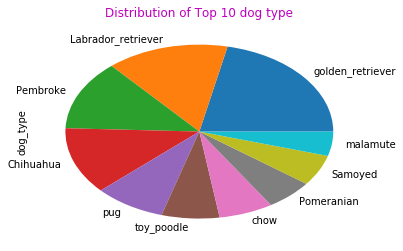

In [448]:
combined_copy['dog_type'].value_counts().head(10).plot(kind='pie')
plt.title('Distribution of Top 10 dog type', color='m')

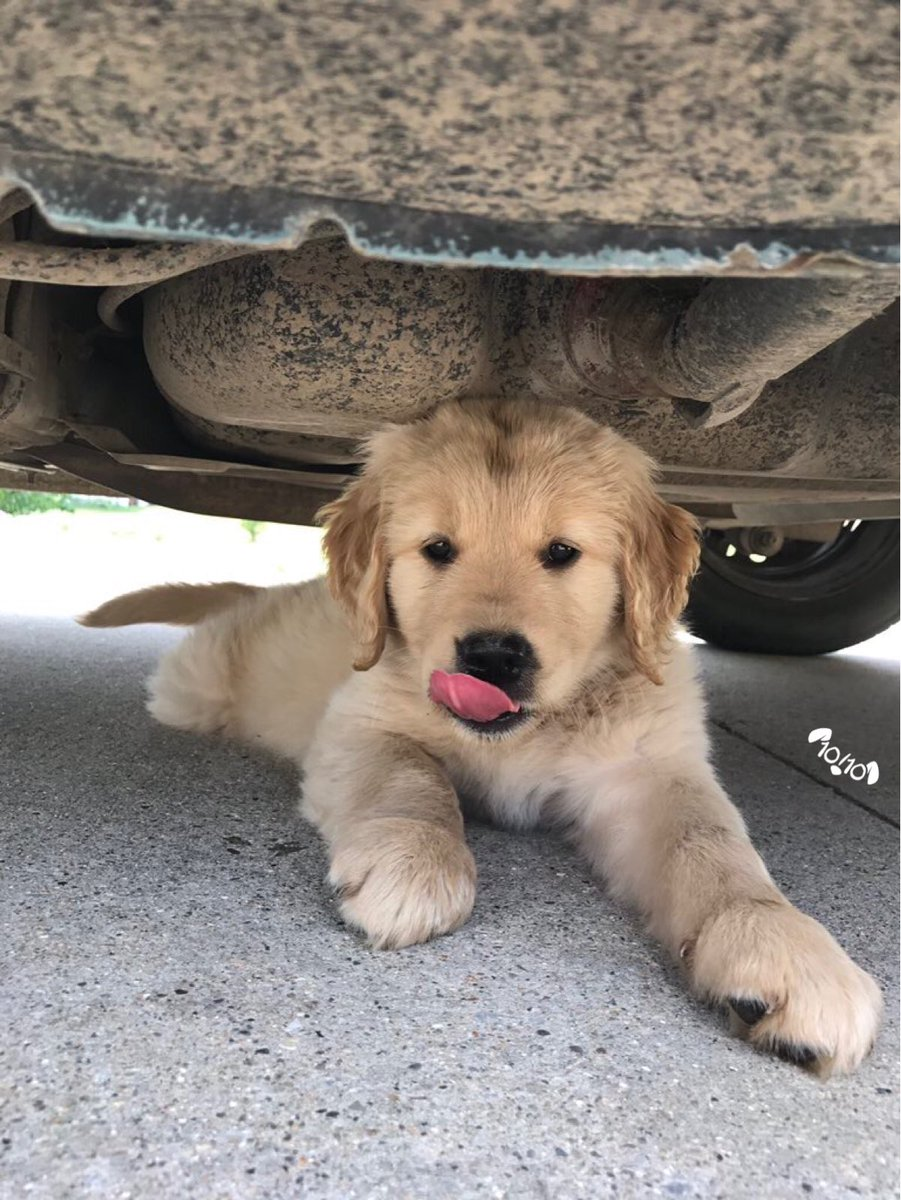

In [428]:
# Image for top dog type 
url = combined_copy[combined_copy['dog_type']== 'golden_retriever'].index
Image(combined_copy.loc[url[13],'jpg_url'])

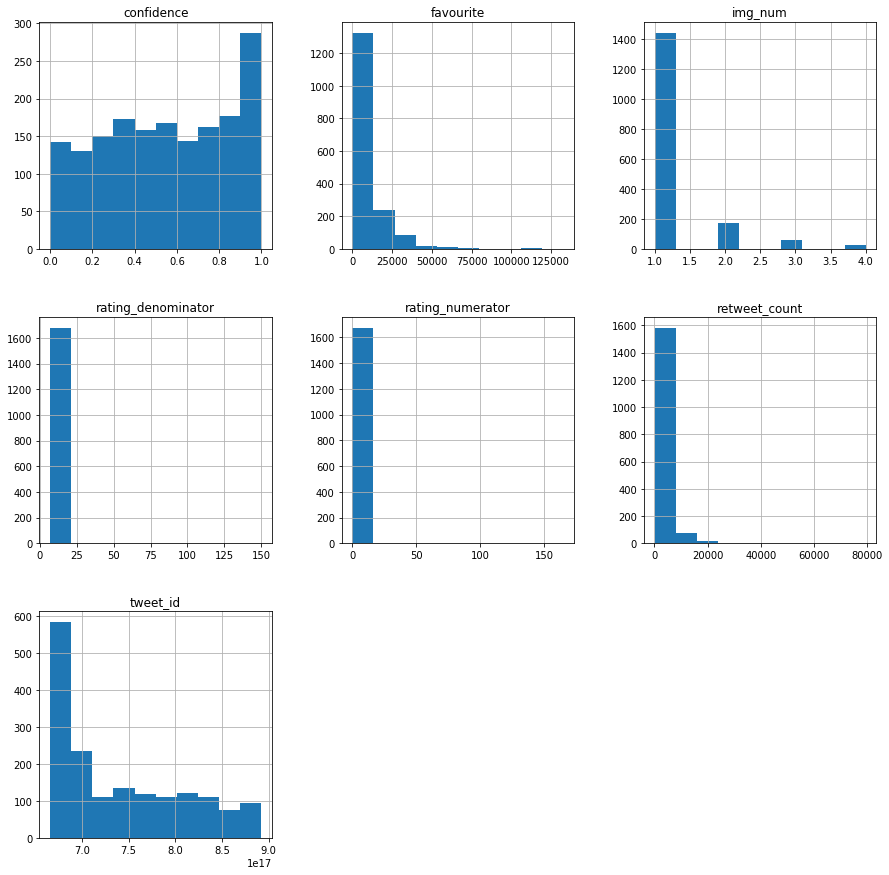

In [363]:
# Drawing Hist for all the columns we have as start
combined_copy.hist(figsize=(15,15));

## The below analysis indicates that the over rated ratings ( > 20 ) get the lowest retweets

## i.e. people retweet the real ratings and most close to sense

Text(0.5,1,'Relation Between retweet count and the rating Numerator')

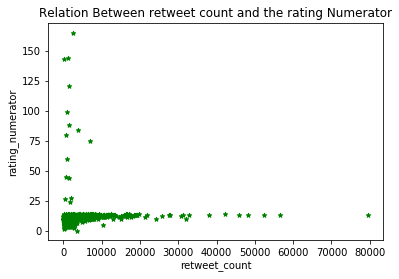

In [362]:
combined_copy.plot(x='retweet_count', y='rating_numerator' , kind = 'scatter' ,color='green' , marker='*')
plt.title('Relation Between retweet count and the rating Numerator')

Text(0.5,1,'Relation Between retweet count and the rating Numerator [ZOOMED]')

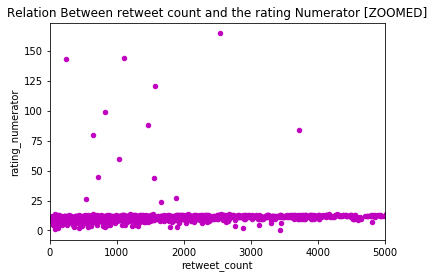

In [456]:
# More zoomed on the highest rating versus the lowest retweets
combined_copy.plot(x='retweet_count', y='rating_numerator' , kind = 'scatter' ,color='m' , marker='o')
y=plt.gca()
y.set_xlim([0,5000])
plt.title('Relation Between retweet count and the rating Numerator [ZOOMED]')

## People seems to retweet the most for the dog as puppo " seems the cutest "

Text(0.5,1,'How retweet acts with different dog age')

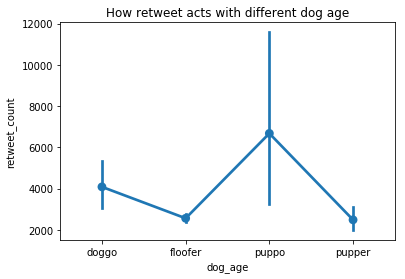

In [380]:
sns.pointplot(x="dog_age", y="retweet_count", jitter=False, data=combined_copy);
plt.title('How retweet acts with different dog age')

## Despite the Puppo has the lowest counts but holds the most retweets

Text(0.5,1,'Contribution of each dog age')

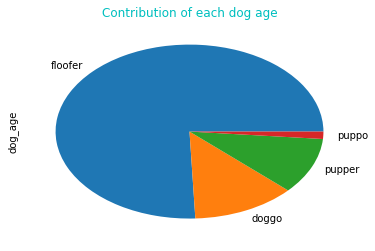

In [457]:
combined_copy['dog_age'].value_counts().plot(kind='pie')
plt.title('Contribution of each dog age' , color='c')

In [458]:
combined_copy['dog_age'].value_counts()

floofer    1280
doggo       211
pupper      177
puppo        23
Name: dog_age, dtype: int64

## Aparently having high image counts doesn't attract high retweets

Text(0.5,1,'Relation Between retweet count and Count of images')

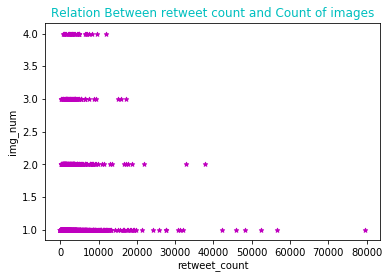

In [453]:
combined_copy.plot(x='retweet_count', y='img_num' , kind = 'scatter' ,color='m' , marker='*')
plt.title('Relation Between retweet count and Count of images' , color ='c')

# Thanks